Install `xlrd` for reading the `xls` file

In [1]:
# %conda install xlrd==2.0.1

Set the path to the `xls` file

In [2]:
training_file = "../TrainDataset2024.xls"
# training_file = "/kaggle/input/dataset/TrainDataset2024.xls"

Import libraries

In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score


from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif

from imblearn.over_sampling import SMOTE

from pickle import dump , load

import warnings

2024-11-30 17:17:38.501232: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-30 17:17:38.528323: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732987058.541870    8853 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732987058.545649    8853 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-30 17:17:38.566778: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

### Cleaning the data

In [4]:
data = pd.read_excel(training_file)
data.drop(["ID", "RelapseFreeSurvival (outcome)"], axis=1, inplace=True)
data_no_na = data.replace(999, np.nan)
data_no_na.dropna(ignore_index=True, inplace=True)
X = data_no_na.drop('pCR (outcome)', axis=1)
y = data_no_na['pCR (outcome)']

print("Read the data into X and y. Dropped all rows with missing value.")

Read the data into X and y. Dropped all rows with missing value.


Split the data into train_full and test (untouched)

In [5]:
X_train_full, X_test_reserved, y_train_full, y_test_reserved = train_test_split(X, y, test_size=0.2, random_state=11)

X_train_full.reset_index(drop=True, inplace=True)
X_test_reserved.reset_index(drop=True, inplace=True)
y_train_full.reset_index(drop=True, inplace=True)
y_test_reserved.reset_index(drop=True, inplace=True)

ratio_train = sum(y_train_full[y_train_full==1]) / len(y_train_full)
ratio_test = sum(y_test_reserved[y_test_reserved==1]) / len(y_test_reserved)

print("Splited the data into train and test. The test will not be used in the training, but just for test the model. ")
print(f"The training data has {len(X_train_full)} data. The testing data has {len(X_test_reserved)} data. ")
print(f"Positive ratio: \n\tTrain: {ratio_train:.5f}\n\tTest: {ratio_test:.5f}")


Splited the data into train and test. The test will not be used in the training, but just for test the model. 
The training data has 246 data. The testing data has 62 data. 
Positive ratio: 
	Train: 0.17073
	Test: 0.17742


### Normalisation

#### Standardisation

In [6]:
scaler = StandardScaler()
Xs_standardisation = scaler.fit_transform(X_train_full)
Xs_standardisation = pd.DataFrame(Xs_standardisation, columns=X_train_full.columns)

with open("pkl/StandardScaler.pkl", "wb") as file:
    dump(scaler, file)
    print("Saved scaler to 'pkl/StandardScaler.pkl'")

Saved scaler to 'pkl/StandardScaler.pkl'


### Robust Scaler

In [7]:
scaler = RobustScaler()
Xs_robustScaler = scaler.fit_transform(X_train_full)
Xs_robustScaler = pd.DataFrame(Xs_robustScaler, columns=X_train_full.columns)

with open("pkl/RobustScaler.pkl", "wb") as file:
    dump(scaler, file)
    print("Saved scaler to 'pkl/RobustScaler.pkl'")

Saved scaler to 'pkl/RobustScaler.pkl'


### Feature Selection

In [8]:
SCALER = "standard"

In [9]:
SCALER = "robust"

In [10]:
if SCALER == "standard":
    Xs = Xs_standardisation
else:
    Xs = Xs_robustScaler

In [11]:
TARGET_NUM_OF_FEATURES = 12

features = {}
for K in range(1, TARGET_NUM_OF_FEATURES + 5):
    best = {}
    for i in range(K+5):
        k_best = SelectKBest(score_func=mutual_info_classif, k=K)
        Xs_k_best = k_best.fit_transform(Xs, y_train_full)
        for feature in (k_best.get_feature_names_out()):
            if feature in best:
                best[feature] += 1
            else:
                best[feature] = 1
    sorted_best = dict(sorted(best.items(), key=lambda item: item[1], reverse=True))
    for key in best:
        if best[key] > (K-2):
            if key in features:
                features[key] += 1
            else:
                features[key] = 1

sorted_best

{'Gene': 21,
 'original_shape_Maximum2DDiameterSlice': 21,
 'original_shape_Maximum3DDiameter': 21,
 'original_firstorder_90Percentile': 21,
 'original_firstorder_InterquartileRange': 21,
 'original_firstorder_Minimum': 21,
 'original_gldm_DependenceNonUniformity': 21,
 'original_gldm_DependenceNonUniformityNormalized': 21,
 'original_glrlm_RunLengthNonUniformityNormalized': 21,
 'original_glrlm_ShortRunEmphasis': 21,
 'original_ngtdm_Strength': 21,
 'original_glrlm_RunLengthNonUniformity': 19,
 'Age': 17,
 'original_glrlm_RunPercentage': 12,
 'ER': 10,
 'PgR': 9,
 'Proliferation': 9,
 'ChemoGrade': 6,
 'HER2': 5,
 'original_gldm_GrayLevelNonUniformity': 5,
 'TumourStage': 5,
 'LNStatus': 3,
 'TrippleNegative': 2,
 'HistologyType': 1,
 'original_ngtdm_Coarseness': 1,
 'original_glszm_GrayLevelVariance': 1}

In [12]:
sorted_features = dict(sorted(features.items(), key=lambda item: item[1], reverse=True))
feature_names = list(sorted_features.keys())
selected_features = feature_names[:TARGET_NUM_OF_FEATURES]
print(f"Best {TARGET_NUM_OF_FEATURES} features are: ")
print(selected_features)

with open("pkl/selected_features.pkl", "wb") as file:
    dump(selected_features, file)

Best 12 features are: 
['Gene', 'original_glrlm_ShortRunEmphasis', 'original_gldm_DependenceNonUniformityNormalized', 'original_firstorder_Minimum', 'original_gldm_DependenceNonUniformity', 'original_glrlm_RunLengthNonUniformityNormalized', 'original_ngtdm_Strength', 'original_shape_Maximum3DDiameter', 'original_firstorder_90Percentile', 'original_shape_Maximum2DDiameterSlice', 'original_firstorder_InterquartileRange', 'Age']


Override auto feature selection

In [13]:
selected_features = feature_names[:6]
with open("pkl/selected_features.pkl", "wb") as file:
    dump(selected_features, file)

#### Resample

In [14]:
Xs_selected = Xs[selected_features]

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(Xs_selected, y_train_full)

print(X_resampled.shape)
print(y_resampled.shape)

(408, 6)
(408,)


#### Decision Tree

In [15]:
# Create a Decision Tree Classifier
model = DecisionTreeClassifier()

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': [2, 3, 4, 5],
    'min_samples_split': [4, 5, 10],
    'min_samples_leaf': [2, 4, 6, 8, 10]
}

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           scoring='accuracy', cv=5, verbose=1, n_jobs=-1, return_train_score=True)

# Fit the model
grid_search.fit(X_resampled, y_resampled)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

pd.DataFrame(grid_search.cv_results_).to_csv('output.csv')

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 4, 'splitter': 'best'}
Best Cross-Validation Score: 0.8481782595603734


Plot best model

Train accuracy: 0.8799328342807827
Test accuracy: 0.8803974706413731


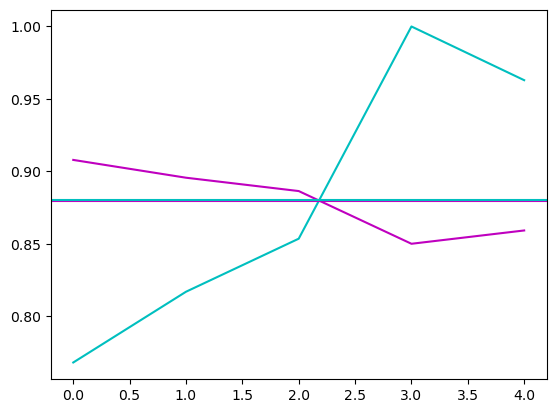

In [16]:
k_folds = KFold(n_splits = 5)
best_model = grid_search.best_estimator_
test_accuracy = []
train_accuracy = []
for train, test in k_folds.split( X_resampled, y_resampled):
  y_pred = best_model.predict(X_resampled.iloc[test])
  test_accuracy.append(accuracy_score(y_resampled[test], y_pred))
  y_pred = best_model.predict(X_resampled.iloc[train])
  train_accuracy.append(accuracy_score(y_resampled[train], y_pred))
plt.clf()
plt.plot(train_accuracy, 'm')
plt.plot(test_accuracy, 'c')
plt.axhline(np.mean(train_accuracy), color='m')
plt.axhline(np.mean(test_accuracy), color='c')

print(f"Train accuracy: {np.mean(train_accuracy)}")
print(f"Test accuracy: {np.mean(test_accuracy)}")

Plot Nth best model

In [17]:
# # Get the indices of the sorted results based on the mean test score
# sorted_indices = np.argsort(grid_search.cv_results_['mean_test_score'])[::-1]

# # Define n for the nth best model
# n = 111  # Change this to get the nth best model (0 for best, 1 for second best, etc.)

# # Get the nth best model parameters
# nth_best_index = sorted_indices[n]
# nth_best_params = grid_search.cv_results_['params'][nth_best_index]
# nth_best_score = grid_search.cv_results_['mean_test_score'][nth_best_index]

# print(f"Parameters for the {n+1}th best model: {nth_best_params}")
# print(f"Mean test score for the {n+1}th best model: {nth_best_score}")

# # Optionally, you can also get the best estimator for further use
# nth_best_model = DecisionTreeClassifier(**nth_best_params)
# nth_best_model.fit(X_resampled, y_resampled)

# test_accuracy = []
# train_accuracy = []
# for train, test in k_folds.split( X_resampled, y_resampled):
#   y_pred = nth_best_model.predict(X_resampled.iloc[test])
#   test_accuracy.append(accuracy_score(y_resampled[test], y_pred))
#   y_pred = nth_best_model.predict(X_resampled.iloc[train])
#   train_accuracy.append(accuracy_score(y_resampled[train], y_pred))
# plt.clf()
# plt.plot(train_accuracy, 'm')
# plt.plot(test_accuracy, 'c')
# plt.axhline(np.mean(train_accuracy), color='m')
# plt.axhline(np.mean(test_accuracy), color='c')

# print(f"Train accuracy: {np.mean(train_accuracy)}")
# print(f"Test accuracy: {np.mean(test_accuracy)}")

Plot models accuracy

<Figure size 640x480 with 0 Axes>

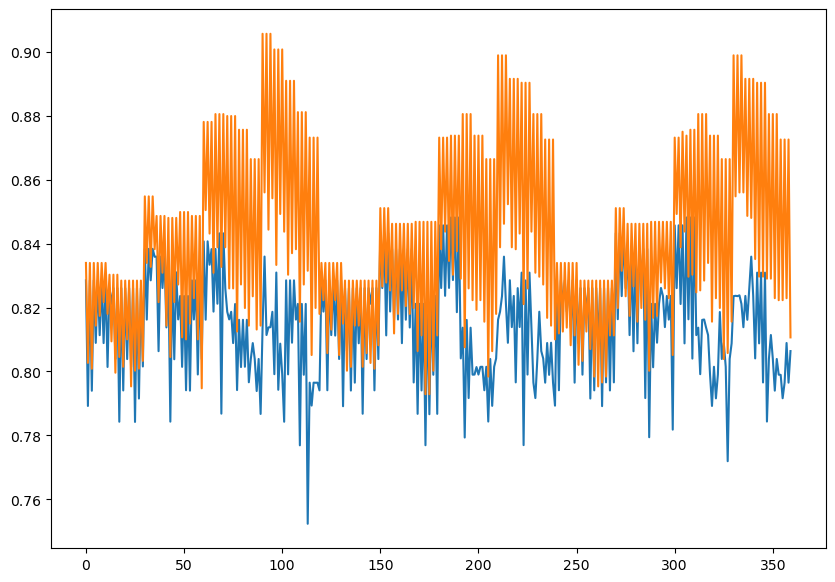

In [18]:
plt.clf()
plt.figure(figsize=(10, 7))
ax = plt.plot(grid_search.cv_results_["mean_test_score"])
ax = plt.plot(grid_search.cv_results_["mean_train_score"])

### Check the accuracy with `test_reserved`

In [19]:
if SCALER == "standard":
    with open("pkl/StandardScaler.pkl", "rb") as file:
        scaler = load(file)
else:
    with open("pkl/robustScaler.pkl", "rb") as file:
        scaler = load(file)

model = grid_search.best_estimator_

X_test = scaler.transform(X_test_reserved)
X_test = pd.DataFrame(X_test, columns=X.columns)

X_test = X_test[selected_features]

y_pred = model.predict(X_resampled)
report = classification_report(y_resampled, y_pred)
cm = confusion_matrix(y_resampled, y_pred)

print(f"TARGET_NUM_OF_FEATURES: {TARGET_NUM_OF_FEATURES}, scaler: {SCALER}")

print("\nBest Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

print("\nTraining set:")
print(report)
print(cm)

y_pred = model.predict(X_test)
report = classification_report(y_test_reserved, y_pred)
cm = confusion_matrix(y_test_reserved, y_pred)

print("Untouched testing set:")
print(report)
print(cm)


TARGET_NUM_OF_FEATURES: 12, scaler: robust

Best Parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 4, 'splitter': 'best'}
Best Cross-Validation Score: 0.8481782595603734

Training set:
              precision    recall  f1-score   support

         0.0       0.96      0.79      0.87       204
         1.0       0.82      0.97      0.89       204

    accuracy                           0.88       408
   macro avg       0.89      0.88      0.88       408
weighted avg       0.89      0.88      0.88       408

[[161  43]
 [  6 198]]
Untouched testing set:
              precision    recall  f1-score   support

         0.0       0.93      0.75      0.83        51
         1.0       0.38      0.73      0.50        11

    accuracy                           0.74        62
   macro avg       0.65      0.74      0.66        62
weighted avg       0.83      0.74      0.77        62

[[38 13]
 [ 3  8]]
